In [1]:
# %% Import the libraries
import skimage
import skimage.filters as filters
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity
from skimage.filters import (
    threshold_otsu,
    threshold_isodata,
    threshold_li,
    threshold_mean,
    threshold_minimum,
    threshold_triangle,
    threshold_yen
)
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import tifffile
from skimage.exposure import match_histograms  # skimage >= 0.18
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
# %% Setup functions
def preprocess_image(
    image,
    image_type,
    reference_image,
    crop_tech='manual',
    contrast_ptiles=(0, 100),
    threshold_method='otsu'
):
    """Extract the individual cell by thresholding & removing background noise.

    Parameters
    ----------
    image : ndarray
        Image data of cell of nervous system.
    image_type : str
        Neuroimaging technique used to get image data of neuronal cell,
        either 'confocal' or 'DAB'.
    reference_image : ndarray
        `image` would be standardized to the exposure level of this example.
    crop_tech : str
        Technique used to crop cell from tissue image,
        either 'manual' or 'auto', by default 'manual'.
    contrast_ptiles : tuple of size 2, optional
        `(low_percentile, hi_percentile)` Contains ends of band of percentile
        values for pixel intensities to which the contrast of cell image
        would be stretched, by default (0, 100)
    threshold_method : str or None, optional
        Automatic single intensity thresholding method to be used for
        obtaining ROI from cell image either of 'otsu', 'isodata', 'li',
        'mean', 'minimum', 'triangle', 'yen'. If None & crop_tech is 'auto' &
        contrast stretch is (0, 100), a single intensity threshold of zero is
        applied, by default 'otsu'

    Returns
    -------
    ndarray
        Thresholded, denoised, boolean transformation of `image` with solid
        soma.

    """
    contrast_ptiles, threshold_method = _validate_img_args(crop_tech,
                                                           contrast_ptiles,
                                                           threshold_method)
    thresholded_image = _threshold_image(image, image_type, reference_image,
                                         crop_tech, contrast_ptiles,
                                         threshold_method)
    cleaned_image = _remove_small_object_noise(thresholded_image)
    cleaned_image_filled_holes = _fill_holes(cleaned_image)

    # Auto-contrast stretching aiding soma detection
    masked_image = cleaned_image_filled_holes * image
    min_intensity, max_intensity = masked_image.min(), masked_image.max()
    image[image < min_intensity] = min_intensity
    image[image > max_intensity] = max_intensity
    image = (image - min_intensity) / (max_intensity - min_intensity)

    return image, cleaned_image_filled_holes


def _threshold_image(
    image,
    image_type,
    reference_image,
    crop_tech,
    contrast_ptiles,
    method
):
    """Single intensity threshold via Otsu's method."""
    if reference_image is not None:
        gray_reference_image = rgb2gray(reference_image)
        image = match_histograms(image, gray_reference_image)

    img_rescale = _contrast_stretching(image, contrast_ptiles)

    THRESHOLD_METHODS = {'otsu': threshold_otsu, 'isodata': threshold_isodata,
                         'li': threshold_li, 'yen': threshold_yen,
                         'mean': threshold_mean, 'minimum': threshold_minimum,
                         'triangle': threshold_triangle}

    if crop_tech == 'auto' and contrast_ptiles == (0, 100) and method is None:
        thresholded_cell = image > 0
    else:
        thresholded_cell = img_rescale > THRESHOLD_METHODS[method](img_rescale)

    if image_type == "DAB":
        return thresholded_cell
    elif image_type == "confocal":
        return invert(thresholded_cell)


def _label_objects(thresholded_image):
    """Label connected regions of a `thresholded_image`."""
    inverted_thresholded_image = invert(thresholded_image)
    bw = closing(inverted_thresholded_image, square(1))
    # label image regions
    labelled_image = label(bw, return_num=True)[0]

    return labelled_image


def _remove_small_object_noise(thresholded_image):
    """Denoise a binary image."""
    labelled_image = _label_objects(thresholded_image)
    labelled_image_1D = labelled_image.reshape(labelled_image.size)
    object_areas = np.bincount(labelled_image_1D[labelled_image_1D != 0])

    largest_object_label = np.argmax(object_areas)
    denoised_image = np.where(labelled_image == [largest_object_label], 1, 0)

    return denoised_image


def _fill_holes(cleaned_image):
    """Fill holes in a binary image."""
    return binary_fill_holes(cleaned_image).astype(int)


def _contrast_stretching(img, contrast_ptiles):
    """Stretches contrast of an image to a band of percentiles of intensities,

    Parameters
    ----------
    img : ndarray
        Image data.
    contrast_ptiles : tuple of size 2
        `(low_percentile, hi_percentile)` Contains ends of band of percentile
        values for pixel intensities to which the contrast of image would be
        stretched

    Returns
    -------
    ndarray
        Contrast rescaled image data.

    """
    p_low, p_hi = np.percentile(img, contrast_ptiles)
    img_rescale = rescale_intensity(img, in_range=(p_low, p_hi))
    return img_rescale

def try_all_threshold(img, contrast_ptiles=(0, 100), figsize=(10, 6)):
    """Applies available automatic single intensity thresholding methods.
    from  https://github.com/swanandlab/SMorph/blob/main/smorph/util/_image.py

    Parameters
    ----------
    img : ndarray
        Image data.
    contrast_ptiles : tuple of size 2, optional
        `(low_percentile, hi_percentile)` Contains ends of band of percentile
        values for pixel intensities to which the contrast of image would be
        stretched, by default (0, 100)
    figsize : tuple, optional
        Figure size (in inches), by default (10, 6)

    """
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = rgb2gray(img)
    img_rescale = _contrast_stretching(img, contrast_ptiles)
    filters.try_all_threshold(img_rescale, figsize, False)
    plt.show()



# Load a candidate image to explore

In [7]:
# %% Set the path to the 3D image
synthetic_3d_tiff_path = r"C:\Users\micha\Documents\Projects\Automatic cell body extraction\dev\Flurocells\drg_cells\2022_10_20_RGB.tif"

# %% Load the  3D image to simulate processing the uploaded file
loaded_3d_image = tifffile.imread(synthetic_3d_tiff_path)

# Explore the maximum projection image in napari
import napari
viewer = napari.view_image(loaded_3d_image)



## Seperate 3D images to 2D images on seperate color planes 

C:\Users\micha\AppData\Local\Temp\ipykernel_1056\2109829508.py:10: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(r"C:\Users\micha\Documents\Projects\Automatic cell body extraction\dev\saved_images\max_intensity_1c.tif", max_intensity_bit)


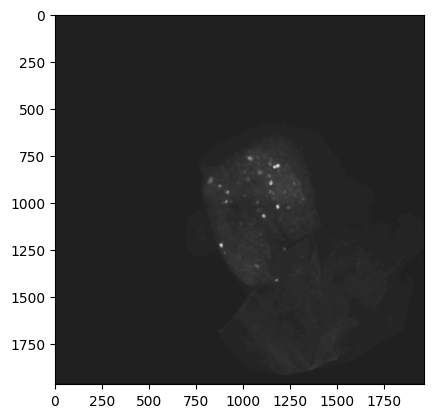

In [14]:
load_imaged_1c = loaded_3d_image[:,:,:,1]

# %%  Perform a maximal intensity Z-projection on the 3D image
max_intensity_projection = np.max(load_imaged_1c, axis=0)
max_intensity_bit = max_intensity_projection.astype(np.uint8) # Convert to 8-bit image (0-255)
# Show the image
plt.imshow(max_intensity_bit, cmap='gray')

# Save max intensity image to saved_images folder
tifffile.imsave(r"C:\Users\micha\Documents\Projects\Automatic cell body extraction\dev\saved_images\max_intensity_1c.tif", max_intensity_bit)


## Perform max projection

C:\Users\micha\AppData\Local\Temp\ipykernel_1056\3573506605.py:8: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(r"C:\Users\micha\Documents\Projects\Automatic cell body extraction\dev\saved_images\max_intensity.tif", max_intensity_bit)


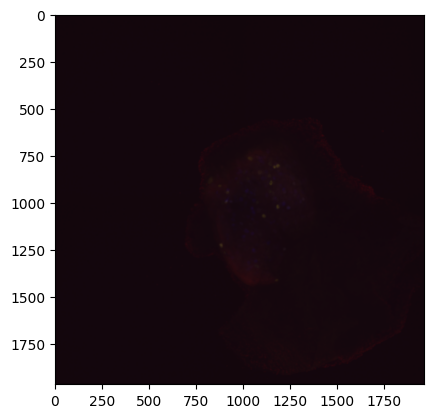

In [5]:
# %%  Perform a maximal intensity Z-projection on the 3D image
max_intensity_projection = np.max(loaded_3d_image, axis=0)
max_intensity_bit = max_intensity_projection.astype(np.uint8) # Convert to 8-bit image (0-255)
# Show the image
plt.imshow(max_intensity_bit, cmap='gray')

# Save max intensity image to saved_images folder
tifffile.imsave(r"C:\Users\micha\Documents\Projects\Automatic cell body extraction\dev\saved_images\max_intensity.tif", max_intensity_bit)


# Explore the image in napari

## Explore impact of median filter

In [ ]:
# %% Explore impact of median filter to smooth the image with a median filter to remove noise (Radius ~ 2 pixels).


def plot_median_filter(image, kernel_size=3):
    """Plot the effect of median filter on image."""
    # Apply median filter to the image
    median_filtered_image = cv2.medianBlur(image, kernel_size)

    # Clear previous output
    clear_output(wait=True)
    
    # Plot the original and median filtered images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(median_filtered_image, cmap='gray')
    plt.title(f'Median Filtered (Kernel Size: {kernel_size})')
    plt.axis('off')
    
    plt.show()

# Initial plot
# plot_median_filter(kernel_size_slider.value)
# # Assuming `max_intensity_bit` is a valid image variable
# # Replace `max_intensity_bit` with the actual image variable you want to use
_ = widgets.interact(plot_median_filter, image=widgets.fixed(max_intensity_bit), kernel_size=widgets.IntSlider(min=1, max=101, step=2, value=3))



## Explore impact on thresholding

In [ ]:
# %% Explore the impact of histogram streteching
def plot_contrast_stretched_image(img, low_percentile, high_percentile):
    """Interactive function to display contrast-stretched image."""
    # Apply contrast stretching
    contrast_stretched_img = _contrast_stretching(img, (low_percentile, high_percentile))
    
    # Clear previous output
    clear_output(wait=True)
    
    # Display the contrast-stretched image
    plt.figure(figsize=(6, 6))
    plt.imshow(contrast_stretched_img, cmap='gray')
    plt.title(f'Contrast-Stretched Image\nLow: {low_percentile}%, High: {high_percentile}%')
    plt.axis('off')
    plt.show()

# Assuming `image` is a predefined image variable you want to use
# Create percentile sliders
low_percentile_slider = widgets.IntSlider(min=0, max=100, step=1, value=2, description='Low Percentile:')
high_percentile_slider = widgets.IntSlider(min=0, max=100, step=1, value=98, description='High Percentile:')

# Display interactive widgets
_ = widgets.interact(plot_contrast_stretched_image, img=widgets.fixed(max_intensity_bit), low_percentile=low_percentile_slider, high_percentile=high_percentile_slider)
